<a href="https://colab.research.google.com/github/makarandmadhavi/AutoML-Marketting-Campaign/blob/main/AutoML_Marketting_Campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoML Marketting Campaign

In this assignment, you will an AutoML library like H2O.ai to create predictive models and interpret them. Find a significant relation for each algorithm of your choosing in your data. Create multivariate models.

For the moment you will assume the data is good. In future assignments, you will check your data, fix data issues and do some feature engineering. 

## About Dataset - Marketing Campaign

Dataset Link - https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

**Context**
A response model can provide a significant boost to the efficiency of a marketing campaign by increasing responses or reducing expenses. The objective is to predict who will respond to an offer for a product or service

**Content**

1. AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise
2. AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
3. AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
4. AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise
5. AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise
6. Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise
7. Complain - 1 if customer complained in the last 2 years
8. DtCustomer - date of customer’s enrolment with the company
9. Education - customer’s level of education
10. Marital - customer’s marital status
11. Kidhome - number of small children in customer’s household
12. Teenhome - number of teenagers in customer’s household
13. Income - customer’s yearly household income
14. MntFishProducts - amount spent on fish products in the last 2 years
15. MntMeatProducts - amount spent on meat products in the last 2 years
16. MntFruits - amount spent on fruits products in the last 2 years
17. MntSweetProducts - amount spent on sweet products in the last 2 years
18. MntWines - amount spent on wine products in the last 2 years
19. MntGoldProds - amount spent on gold products in the last 2 years
20. NumDealsPurchases - number of purchases made with discount
21. NumCatalogPurchases - number of purchases made using catalogue
22. NumStorePurchases - number of purchases made directly in stores
23. NumWebPurchases - number of purchases made through company’s web site
24. NumWebVisitsMonth - number of visits to company’s web site in the last month
25. Recency - number of days since the last purchase

Answer the following questions for all of the models:

* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

* Coding professionalism?

In [93]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
#Importing required packages
import h2o
from h2o.automl import H2OAutoML
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

# EDA Data Cleaning and feature engineering

In [95]:
data = pd.read_csv("https://raw.githubusercontent.com/makarandmadhavi/ML-Data-Cleaning-and-Feature-Selection/main/marketing_campaign.csv", sep=";")
data.drop(columns = ["Z_CostContact","Z_Revenue","ID",],inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

In [96]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,3,6,5,0,0,0,0,0,0,0


In [97]:
data['Income'].fillna(data.groupby('Education')['Income'].transform('mean'), inplace = True)
data['Year_Birth'] = data['Year_Birth'].apply(lambda x: 2020-x)
data = data.rename(columns={'Year_Birth': 'Age'})

Education_map = {'Basic':1,
            'Graduation':2,
            'Master':3,
            '2n Cycle':3,
            'PhD':4}
# Create the mapped values in a new column
data['Education'] = data['Education'].map(Education_map)

from datetime import datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%Y-%m-%d')
data['Dt_Customer'] = (datetime(2020,1,1) - data['Dt_Customer']).dt.days

data['Children'] = data['Kidhome'] + data['Teenhome']
data.drop(columns = ["Kidhome","Teenhome"],inplace = True)

data['AmountSpent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']
data.drop(columns = ["MntWines",	"MntFruits"	,"MntMeatProducts",	"MntFishProducts","MntSweetProducts",	"MntGoldProds"],inplace = True)

data['NumPurchased'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases']
data.drop(columns = ["NumWebPurchases",	"NumCatalogPurchases",	"NumStorePurchases"],inplace = True)

data['Prev_campaigns'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5']
data.drop(columns = ["AcceptedCmp3",	"AcceptedCmp4",	"AcceptedCmp5",	"AcceptedCmp1",	"AcceptedCmp2"],inplace = True)

maratial_map = {'Married':"Couple",
            'Together':"Couple",
            'Single':'Single',
            'Divorced':'Single',
            'Widow':'Single',
            'Alone':'Single',
            'Absurd':'Single',
            'YOLO':'Single'}
# Create the mapped values in a new column
data['Marital_Status'] = data['Marital_Status'].map(maratial_map)

dummy_status = pd.get_dummies(data['Marital_Status'], prefix='Marital_Status')

data = pd.concat([data, dummy_status], axis=1)
data.drop(['Marital_Status'], axis=1, inplace=True)

data.head()

,Age,Education,Income,Dt_Customer,Recency,NumDealsPurchases,NumWebVisitsMonth,Complain,Response,Children,AmountSpent,NumPurchased,Prev_campaigns,Marital_Status_Couple,Marital_Status_Single
0,63,2,58138.0,2675,58,3,7,0,1,0,1617,22,0,0,1
1,66,2,46344.0,2125,38,2,5,0,0,2,27,4,0,0,1
2,55,2,71613.0,2324,26,1,4,0,0,0,776,20,0,1,0
3,36,2,26646.0,2151,26,2,6,0,0,1,53,6,0,1,0
4,39,4,58293.0,2173,94,5,5,0,0,1,422,14,0,1,0


In [98]:
data.Income.quantile(0.99)

94437.68000000001

In [99]:
data.drop(data[data['Income'] >= 93651].index, inplace = True)

In [100]:
data.isnull().sum()

Age                      0
Education                0
Income                   0
Dt_Customer              0
Recency                  0
NumDealsPurchases        0
NumWebVisitsMonth        0
Complain                 0
Response                 0
Children                 0
AmountSpent              0
NumPurchased             0
Prev_campaigns           0
Marital_Status_Couple    0
Marital_Status_Single    0
dtype: int64

[Text(0, 0, 'Age'),
 Text(1, 0, 'Education'),
 Text(2, 0, 'Income'),
 Text(3, 0, 'Dt_Customer'),
 Text(4, 0, 'Recency'),
 Text(5, 0, 'NumDealsPurchases'),
 Text(6, 0, 'NumWebVisitsMonth'),
 Text(7, 0, 'Complain'),
 Text(8, 0, 'Response'),
 Text(9, 0, 'Children'),
 Text(10, 0, 'AmountSpent'),
 Text(11, 0, 'NumPurchased'),
 Text(12, 0, 'Prev_campaigns'),
 Text(13, 0, 'Marital_Status_Couple'),
 Text(14, 0, 'Marital_Status_Single')]

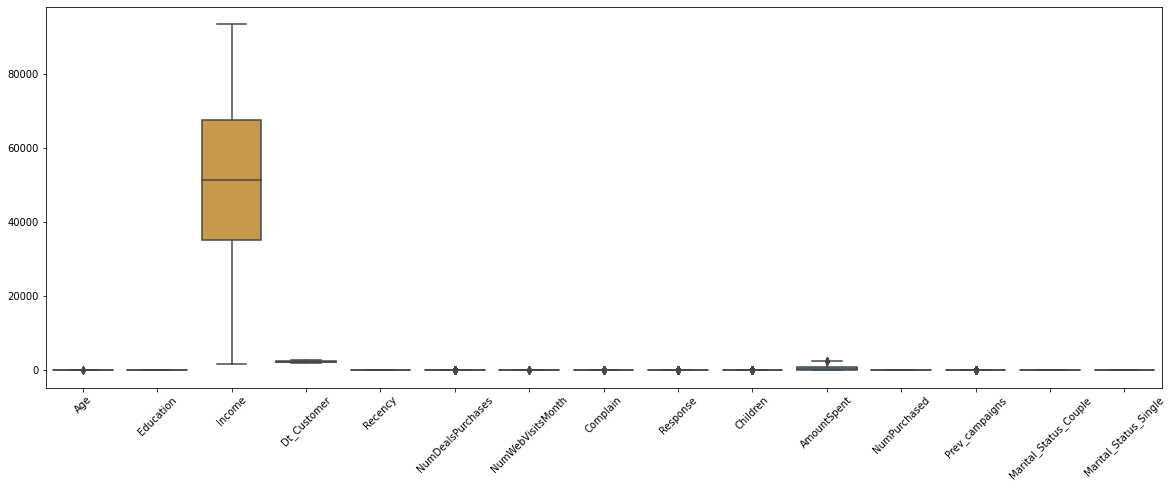

In [101]:
plt.figure(figsize=(20,7))
x = sns.boxplot(data=data)
x.set_xticklabels(x.get_xticklabels(),rotation=45)

<AxesSubplot:>

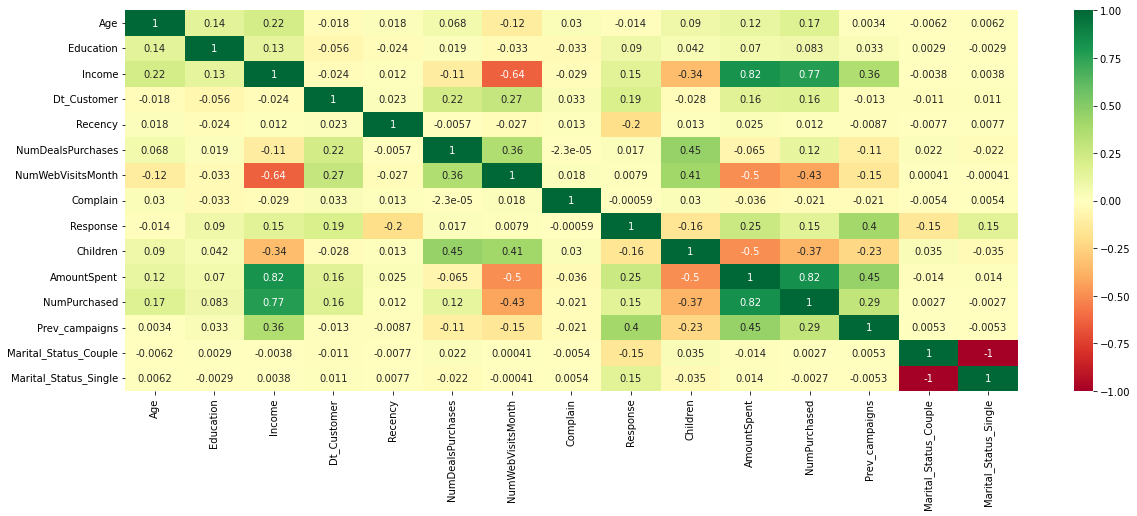

In [102]:
plt.figure(figsize=(20,7))
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')


## Correlation Analysis

The above heatmap shows us some relationship -


*   Amount spent and NumPurchased is highly correlated which is obvious since more the items purchases more is gonna be total amount spent
*   Income in turn is highly correlated with Amount spent and NumPurchased which suggests these 3 data points might be suggesting the same thing



# H20 AutoML

In [103]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 24 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_unknownUser_00lweb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.061 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [104]:
df = h2o.H2OFrame(data)
df["Response"] = df["Response"].asfactor()
df.describe(chunk_summary=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:2214
Cols:15

Chunk compression summary: 
chunk_type    chunk_name                 count    count_percentage    size     size_percentage
------------  -------------------------  -------  ------------------  -------  -----------------
CBS           Binary                     3        20                  1.0 KB   2.25388
CXI           Sparse Integers            1        6.66667             118  B   0.255483
C1N           1-Byte Integers (w/o NAs)  8        53.3333             17.8 KB  39.5263
C2            2-Byte Integers            2        13.3333             8.8 KB   19.4687
C8D           64-bit Reals               1        6.66667             17.4 KB  38.4957

Frame distribution summary: 
                 size     number_of_rows    number_of_chunks_per_column    number_of_chunks
---------------  -------  ----------------  -----------------------------  ------------------
127.0.0.1:54321  45.1 KB  2214              1                              15
mean             45.1 KB  2214              1                              15
min              45.1 KB  2214              1                              15
max              45.1 KB  2214              1                              15
stddev           0  B     0                 0                              0
total            45.1 KB  2214              1                              15

,Age,Education,Income,Dt_Customer,Recency,NumDealsPurchases,NumWebVisitsMonth,Complain,Response,Children,AmountSpent,NumPurchased,Prev_campaigns,Marital_Status_Couple,Marital_Status_Single
type,int,int,real,int,int,int,int,int,enum,int,int,int,int,int,int
mins,24.0,1.0,1730.0,2012.0,0.0,0.0,0.0,0.0,,0.0,5.0,0.0,0.0,0.0,0.0
mean,51.21318879855459,2.6644083107497774,51266.54151810947,2365.746160794945,49.175700090334274,2.333785004516709,5.355465221318874,0.009485094850948509,,0.9579945799457986,597.1404697380312,12.468383017163509,0.2836495031616975,0.6454381210478771,0.3545618789521229
maxs,127.0,4.0,93404.0,2711.0,99.0,15.0,20.0,1.0,,3.0,2525.0,32.0,4.0,1.0,1.0
sigma,11.971976898459362,0.8389671998614283,20244.354655689065,202.18840379501523,28.94522190386703,1.8937351087986132,2.4064276849329103,0.0969503648918201,,0.7500846453017618,594.2820231606587,7.1490264841217295,0.6544602133173475,0.4784884153133252,0.4784884153133252
zeros,0,0,0,0,28,30,7,2193,,618,0,4,1768,785,1429
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,63.0,2.0,58138.0,2675.0,58.0,3.0,7.0,0.0,1,0.0,1617.0,22.0,0.0,0.0,1.0
1,66.0,2.0,46344.0,2125.0,38.0,2.0,5.0,0.0,0,2.0,27.0,4.0,0.0,0.0,1.0
2,55.0,2.0,71613.0,2324.0,26.0,1.0,4.0,0.0,0,0.0,776.0,20.0,0.0,1.0,0.0


In [105]:
train, test, valid = df.split_frame(ratios=[0.7, 0.15], seed=1)

In [106]:

aml = H2OAutoML(max_models=10, balance_classes=True, seed=1)
aml.train(training_frame = train, y = 'Response')


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),7/10
# GBM base models (used / total),2/4
# XGBoost base models (used / total),2/3
# GLM base models (used / total),1/1
# DRF base models (used / total),2/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


## Understanding the Terminologies

**MSE** (Mean Squared Error) is a commonly used metric for evaluating regression models that measures the average of the squared differences between the predicted values and the actual values.

**RMSE** (Root Mean Squared Error) is the square root of the MSE and is also used as a metric for evaluating regression models. It is preferred over MSE because it is in the same units as the target variable and is easier to interpret.

**LogLoss** (Logarithmic Loss) is a commonly used metric for evaluating classification models that measures the performance of the model based on the predicted probabilities. It penalizes the model more heavily for incorrect predictions with high confidence.

**AUC** (Area Under the Curve) is a metric for evaluating binary classification models that measures the performance of the model across all possible threshold values. It represents the probability that a randomly chosen positive example will be ranked higher than a randomly chosen negative example.

**AUCPR** (Area Under the Precision-Recall Curve) is another metric for evaluating binary classification models that measures the trade-off between precision and recall. It represents the average precision across all possible threshold values.

**Gini** is a metric for evaluating classification models that measures the difference between the observed distribution of class labels and the expected distribution under random chance. It is often used in conjunction with the AUC.

**Null degrees of freedom and residual degrees of freedom** are used in statistical models to describe the number of parameters estimated and the number of independent observations used in the model. The null degrees of freedom represent the number of parameters estimated in a null model (usually a model with no predictors), and the residual degrees of freedom represent the number of independent observations minus the number of parameters estimated in the full model.

**Null deviance and residual deviance** are measures of the goodness-of-fit of a statistical model. The null deviance represents the deviance of a null model (usually a model with no predictors), and the residual deviance represents the deviance of the full model after accounting for the predictors.

**AIC** (Akaike Information Criterion) is a measure of the relative quality of a statistical model for a given set of data. It balances the goodness-of-fit of the model with the complexity of the model, penalizing models with a larger number of parameters. Lower values of AIC indicate a better fit.


In [107]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_3_20230301_04325,0.888569,0.265755,0.612972,0.215668,0.282515,0.0798148
StackedEnsemble_BestOfFamily_1_AutoML_3_20230301_04325,0.88736,0.266584,0.614109,0.20715,0.282752,0.079949
GBM_1_AutoML_3_20230301_04325,0.881397,0.280038,0.602335,0.203489,0.292234,0.0854005
GBM_2_AutoML_3_20230301_04325,0.872627,0.306826,0.563568,0.241598,0.305533,0.0933502
GLM_1_AutoML_3_20230301_04325,0.86837,0.282188,0.586975,0.241227,0.291058,0.0847146
XGBoost_1_AutoML_3_20230301_04325,0.867836,0.361198,0.547944,0.22386,0.336237,0.113055
DRF_1_AutoML_3_20230301_04325,0.866708,0.52891,0.539586,0.222759,0.325012,0.105633
XRT_1_AutoML_3_20230301_04325,0.865925,0.356223,0.518215,0.191714,0.330064,0.108942
GBM_4_AutoML_3_20230301_04325,0.865716,0.321793,0.549785,0.230162,0.311148,0.0968129
XGBoost_3_AutoML_3_20230301_04325,0.863419,0.339966,0.538389,0.213558,0.321774,0.103538


## Model Leaderboard

The above leaderboard shows models ranked according to their AUC, with highest AUC being the best performing model

Our best performing model is StackedEnsemble_AllModels_1_AutoML_3_20230301_04325 which is a stacked Ensemble model made by combining different GBM XGBoost or XRT models

In [108]:
#Getting the best model
best_model = h2o.get_model(lb[0,"model_id"])
best_model.model_performance(test)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.08524042271705969
RMSE: 0.2919596251488546
LogLoss: 0.2880448240494668
AUC: 0.877859477124183
AUCPR: 0.6756125706190707
Gini: 0.755718954248366
Null degrees of freedom: 314
Residual degrees of freedom: 307
Null deviance: 279.83912568812303
Residual deviance: 181.46823915116406
AIC: 197.46823915116406

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5190202888670029
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      260  4    0.0152   (4.0/264.0)
1      26   25   0.5098   (26.0/51.0)
Total  286  29   0.0952   (30.0/315.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.51902      0.625     28
max f2                       0.162318     0.692042  83
max f0point5                 0.51902      0.748503  28
max accuracy                 0.51902      0.904762  28
max precision                0.979066     1         0
max recall                   0.00475232   1         267
max specificity              0.979066     1         0
max absolute_mcc             0.51902      0.605256  28
max min_per_class_accuracy   0.162318     0.784314  83
max mean_per_class_accuracy  0.162318     0.80693   83
max tns                      0.979066     264       0
max fns                      0.979066     50        0
max fps                      4.39122e-05  264       312
max tps                      0.00475232   51        267
max tnr                      0.979066     1         0
max fnr                      0.979066     0.980392  0
max fpr                      4.39122e-05  1         312
max tpr                      0.00475232   1         267

Gains/Lift Table: Avg response rate: 16.19 %, avg score: 14.08 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0126984                   0.93898            6.17647   6.17647            1                0.966033    1                           0.966033            0.0784314       0.0784314                  517.647   517.647            0.0784314
2        0.0222222                   0.856435           6.17647   6.17647            1                0.902612    1                           0.938852            0.0588235       0.137255                   517.647   517.647            0.137255
3        0.031746                    0.807135           4.11765   5.55882            0.666667         0.826328    0.9                         0.905095            0.0392157       0.176471                   311.765   455.882            0.172683
4        0.0412698                   0.749886           4.11765   5.22624            0.666667         0.794041    0.846154                    0.879467            0.0392157       0.215686                   311.765   422.624            0.208111
5        0.0507937                   0.647174           6.17647   5.40441            1                0.68911     0.875                       0.843775            0.0588235       0.27451                    517.647   440.441            0.266934
6        0.101587                    0.449905           4.24632   4.82537            0.6875           0.563966    0.78125                     0.70387             0.215686        0.490196                   324.632   382.537            0.463681
7        0.152381                    0.281724           1.93015   3.86029            0.3125           0.342218    0.625                       0.58332            

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

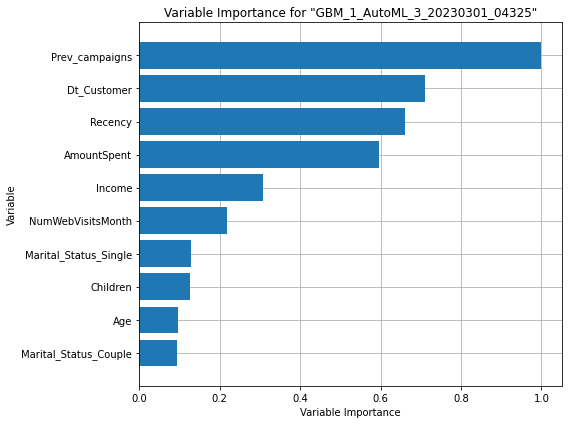

In [109]:
explain_model = aml.explain(frame = test, figsize = (8,6),include_explanations=['varimp'])


## Variable Importance

*   The above graph shows prev_campaigns has the highest variable importance which was expected as a customer who has previously reponded to a campaign is more likely to respond to a new campaign
*   The lease important column being Maritial_status dummy column, age and number of children with less than 20% importance as compared to prev_campaigns




# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

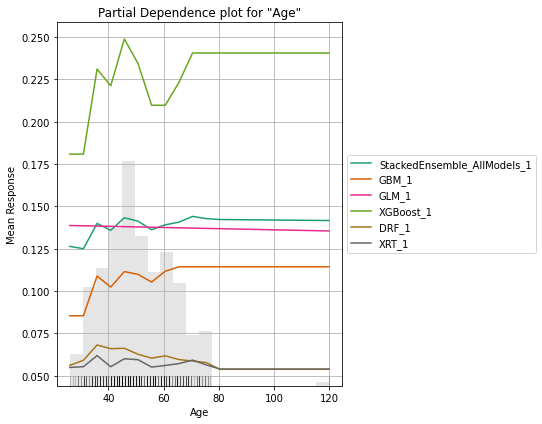

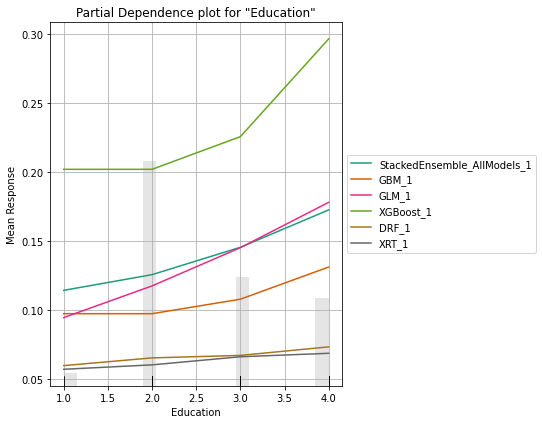

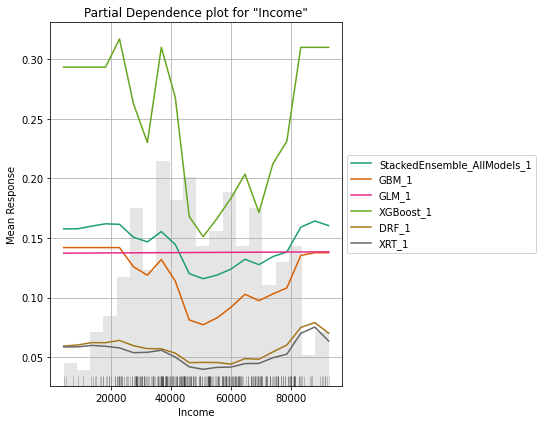

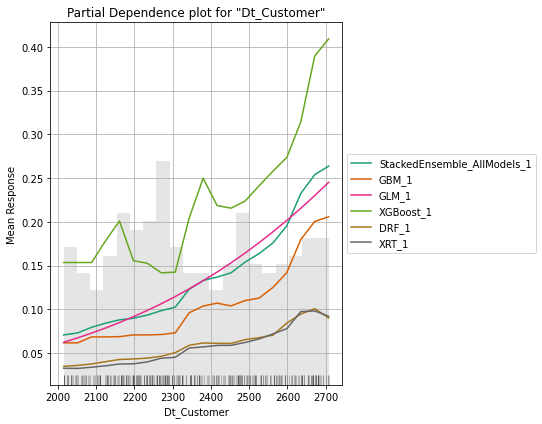

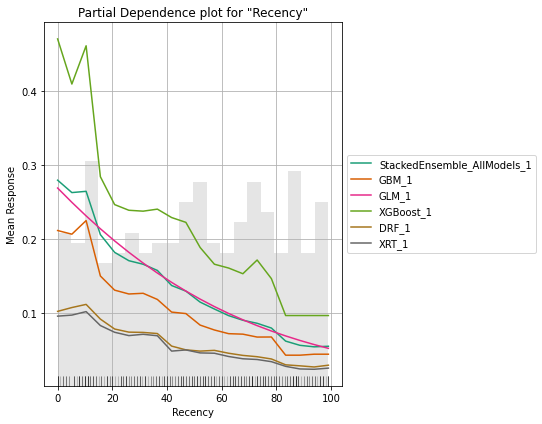

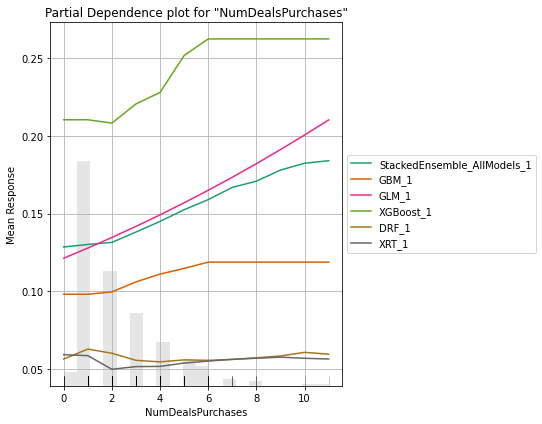

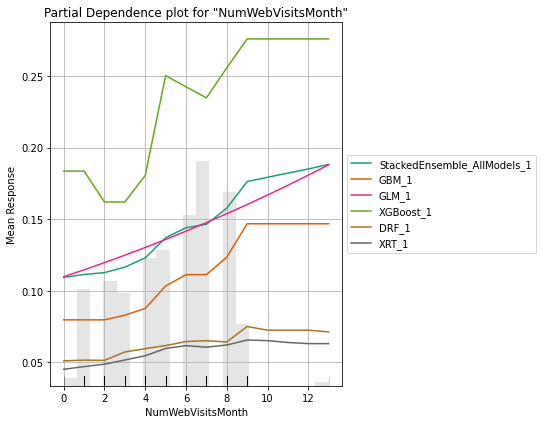

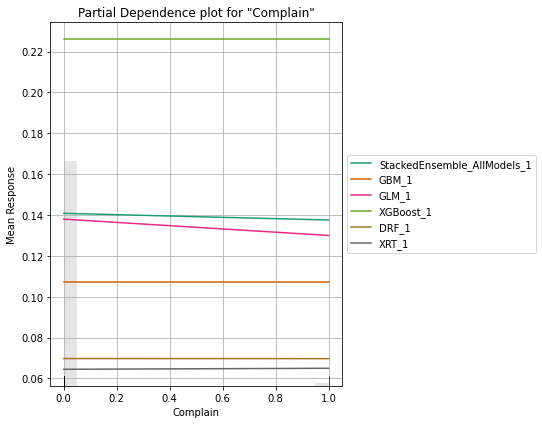

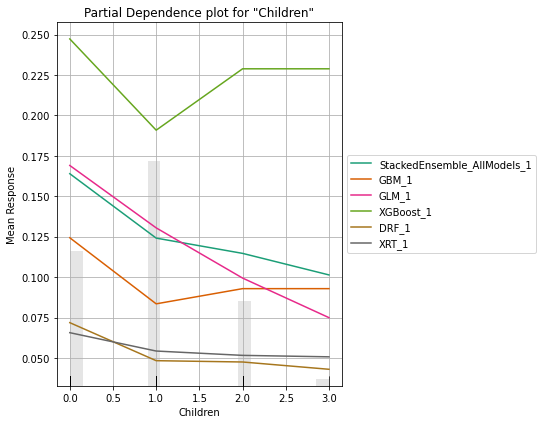

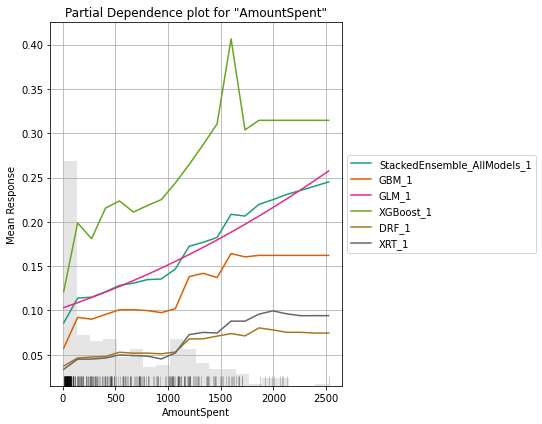

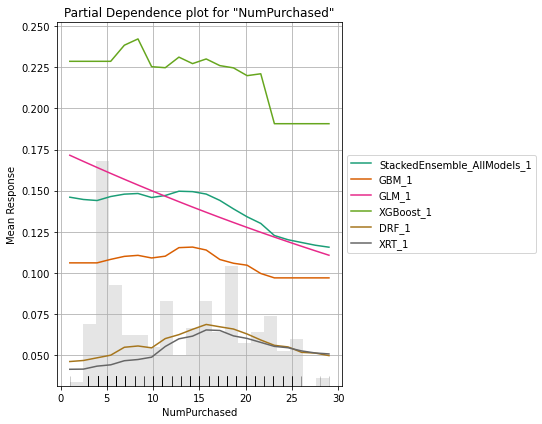

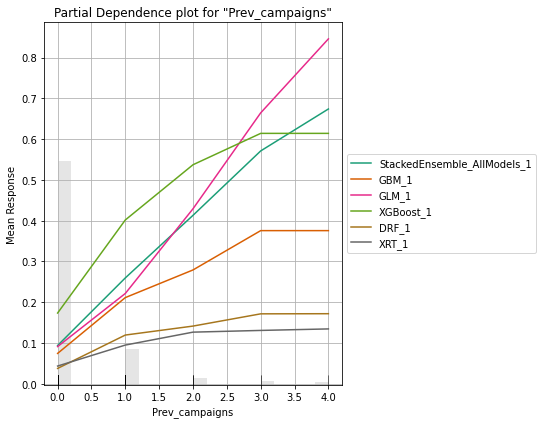

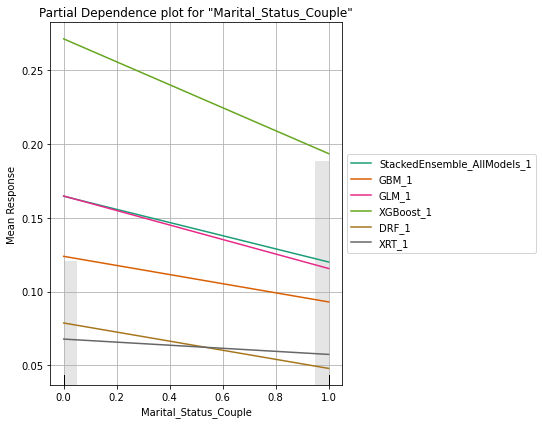

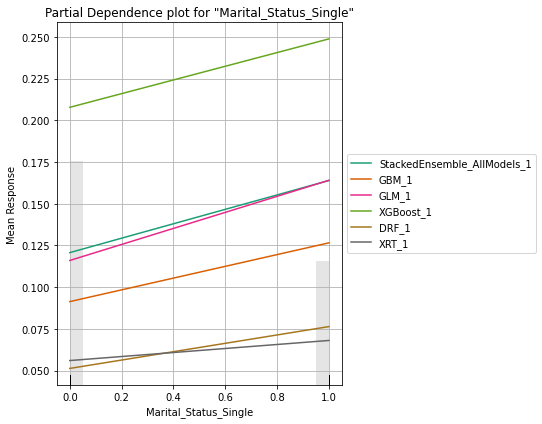

In [110]:
explain_model = aml.explain(frame = test, figsize = (8,6),include_explanations=['pdp'])


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

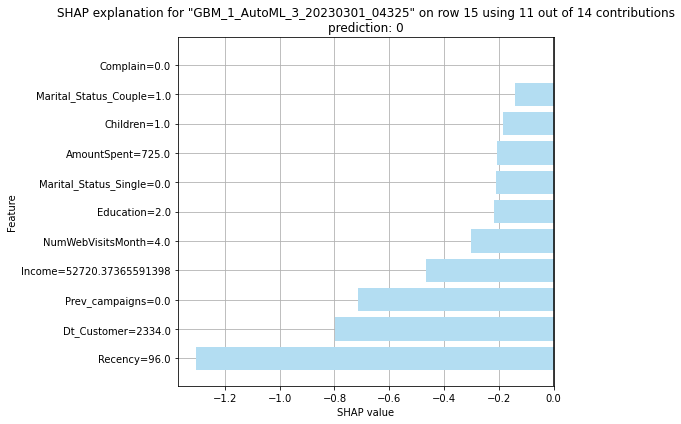

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

In [111]:
aml.explain_row(frame = test, row_index = 15, figsize = (8,6), exclude_explanations = "leaderboard")


# Ridge Regularization in H20

In [112]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# set the response column and predictor columns
response_col = "Response"
predictor_cols = df.columns
predictor_cols.remove("Response")

# create a logistic regression model with Ridge regularization
glm = H2OGeneralizedLinearEstimator(family="binomial", alpha=0, lambda_=0.1)

# train the model on your data
glm.train(x=predictor_cols, y=response_col, training_frame=train)

# view the model performance metrics
print(glm.model_performance())

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.09020253734873865
RMSE: 0.30033737254750476
LogLoss: 0.3037024448522226
AUC: 0.8664487369985141
AUCPR: 0.5919824693416983
Gini: 0.7328974739970282
Null degrees of freedom: 1570
Residual degrees of freedom: 1556
Null deviance: 1290.6315009362133
Residual deviance: 954.2330817256833
AIC: 984.2330817256833

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2222110231451709
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      1224  122  0.0906   (122.0/1346.0)
1      88    137  0.3911   (88.0/225.0)
Total  1312  259  0.1337   (210.0/1571.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.222211     0.566116  153
max f2                     

# Hyper Parameter Tunning

In [113]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

In [114]:
hyper_params = {
    "learn_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "sample_rate": [0.8, 0.9, 1.0],
    "col_sample_rate": [0.8, 0.9, 1.0]
}
search_criteria = {"strategy": "RandomDiscrete", "max_models": 36, "seed": 1}

In [115]:
gbm_grid = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id="gbm_grid2",
    hyper_params=hyper_params,
    search_criteria=search_criteria,
)

gbm_grid.train(
    x=predictor_cols, y=response_col, training_frame=train, validation_frame=valid, ntrees=100, seed=1
)



gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,logloss
,1.0,0.1,5.0,0.9,gbm_grid2_model_15,0.2258659
,1.0,0.1,5.0,0.9,gbm_grid2_model_51,0.2258659
,1.0,0.1,5.0,1.0,gbm_grid2_model_42,0.2259809
,1.0,0.1,5.0,1.0,gbm_grid2_model_6,0.2259809
,1.0,0.05,7.0,1.0,gbm_grid2_model_13,0.2282228
,1.0,0.05,7.0,1.0,gbm_grid2_model_49,0.2282228
,0.9,0.05,7.0,0.9,gbm_grid2_model_30,0.2284321
,0.9,0.05,7.0,0.9,gbm_grid2_model_66,0.2284321
,0.9,0.05,5.0,0.9,gbm_grid2_model_3,0.2304096
,0.9,0.05,5.0,0.9,gbm_grid2_model_39,0.2304096


In [116]:
parameterGrid = gbm_grid.get_grid(sort_by="logloss", decreasing=False)


In [117]:
list_hyperparameters = []
for i in range(36):
    list_hyperparameters.append(parameterGrid.get_hyperparams_dict(i))

Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperp

In [118]:
models = parameterGrid.models

In [119]:
list_logloss = []
for i in range(36):
    model = models[i]
    performance_metrics = model.model_performance(valid)
    logloss = performance_metrics.logloss()
    list_logloss.append(logloss)

In [120]:
for i in range(36):
    list_hyperparameters[i]["logloss"] = list_logloss[i]

In [121]:
hyperparameters_dataframe = pd.DataFrame(list_hyperparameters)
hyperparameters_dataframe

,col_sample_rate,learn_rate,max_depth,sample_rate,logloss
0,1.0,0.10,5,0.9,0.225866
1,1.0,0.10,5,0.9,0.225866
2,1.0,0.10,5,1.0,0.225981
3,1.0,0.10,5,1.0,0.225981
4,1.0,0.05,7,1.0,0.228223
5,1.0,0.05,7,1.0,0.228223
6,0.9,0.05,7,0.9,0.228432
7,0.9,0.05,7,0.9,0.228432
8,0.9,0.05,5,0.9,0.230410
9,0.9,0.05,5,0.9,0.230410


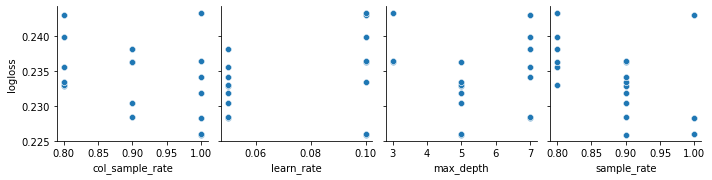

In [122]:
sns.pairplot(
    hyperparameters_dataframe,
    y_vars=["logloss"],
    x_vars=["col_sample_rate", "learn_rate", "max_depth", "sample_rate"],
)

**Hyperparameter Tuning Analysis**

This is a summary of hyperparameter tuning for an XGBoost model, which involved a grid search over a range of values for four hyperparameters: col_sample_rate, learn_rate, max_depth, and sample_rate. The search resulted in a total of 36 combinations of hyperparameters, and for each combination, the logloss was calculated as an evaluation metric.



*   Based on the results, the hyperparameter combination with the lowest logloss was a model with col_sample_rate of 1.0, learn_rate of 0.10, max_depth of 5, and sample_rate of 0.9, with a logloss of 0.225866. The worst-performing models had logloss of 0.319389.

*   Overall, the results suggest that the combination of col_sample_rate, learn_rate, max_depth, and sample_rate can have a significant impact on the performance of an XGBoost model, and that hyperparameter tuning can lead to significant improvements in model performance.


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_1_AutoML_3_20230301_04325,0.878528,0.28909,0.673977,0.254234,0.292933,0.0858097,4634,0.112542,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_3_20230301_04325,0.877859,0.288045,0.675613,0.262478,0.29196,0.0852404,4180,0.128454,StackedEnsemble
GBM_1_AutoML_3_20230301_04325,0.872958,0.314428,0.649125,0.252005,0.307049,0.094279,966,0.033488,GBM
GLM_1_AutoML_3_20230301_04325,0.872958,0.298533,0.645523,0.182041,0.300779,0.0904679,144,0.017719,GLM
XGBoost_2_AutoML_3_20230301_04325,0.870878,0.31924,0.64653,0.214015,0.31055,0.0964414,1616,0.024302,XGBoost
XGBoost_1_AutoML_3_20230301_04325,0.866867,0.345509,0.630973,0.196524,0.331565,0.109935,686,0.024972,XGBoost
DRF_1_AutoML_3_20230301_04325,0.857175,0.492617,0.615445,0.251671,0.330219,0.109045,2006,0.055061,DRF
GBM_2_AutoML_3_20230301_04325,0.856023,0.34549,0.63737,0.227273,0.315357,0.0994501,758,0.029094,GBM
GBM_3_AutoML_3_20230301_04325,0.846071,0.364042,0.601355,0.215575,0.323827,0.104864,685,0.027908,GBM
XGBoost_3_AutoML_3_20230301_04325,0.843026,0.370862,0.596829,0.234848,0.333094,0.110952,295,0.024598,XGBoost


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_3_20230301_04325

,0,1,Error,Rate
0,260.0,4.0,0.0152,(4.0/264.0)
1,26.0,25.0,0.5098,(26.0/51.0)
Total,286.0,29.0,0.0952,(30.0/315.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

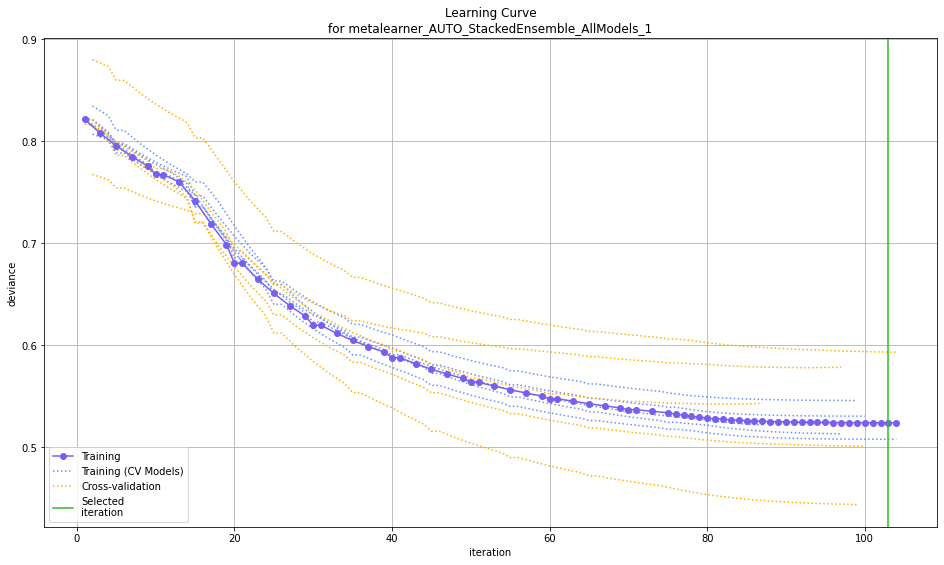

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

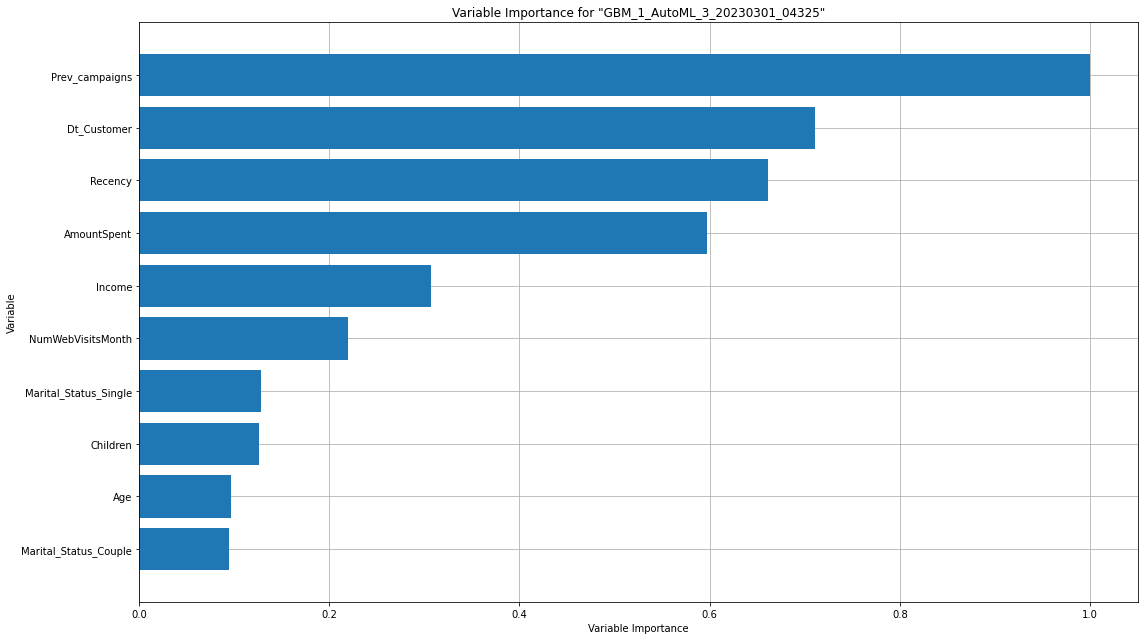

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

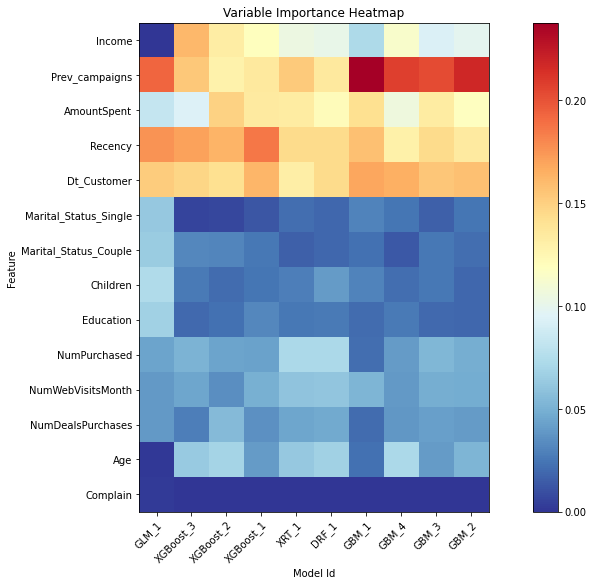

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

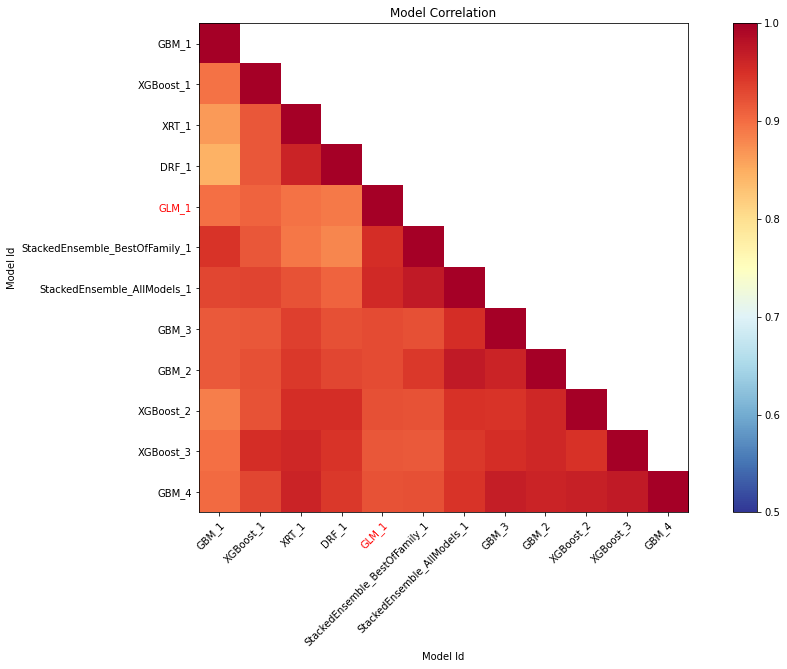

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

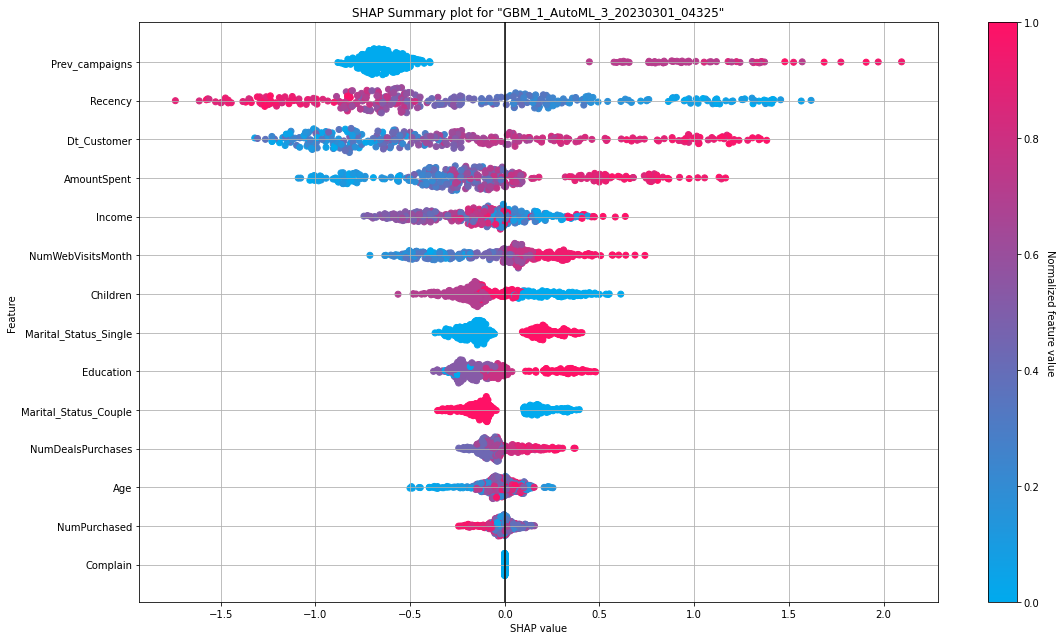

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

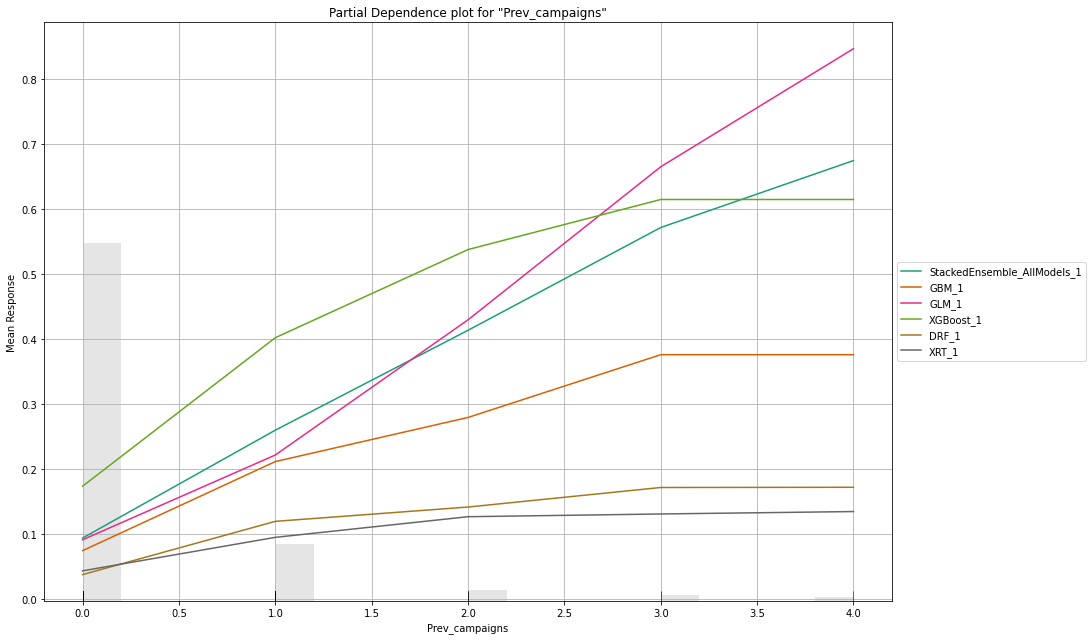

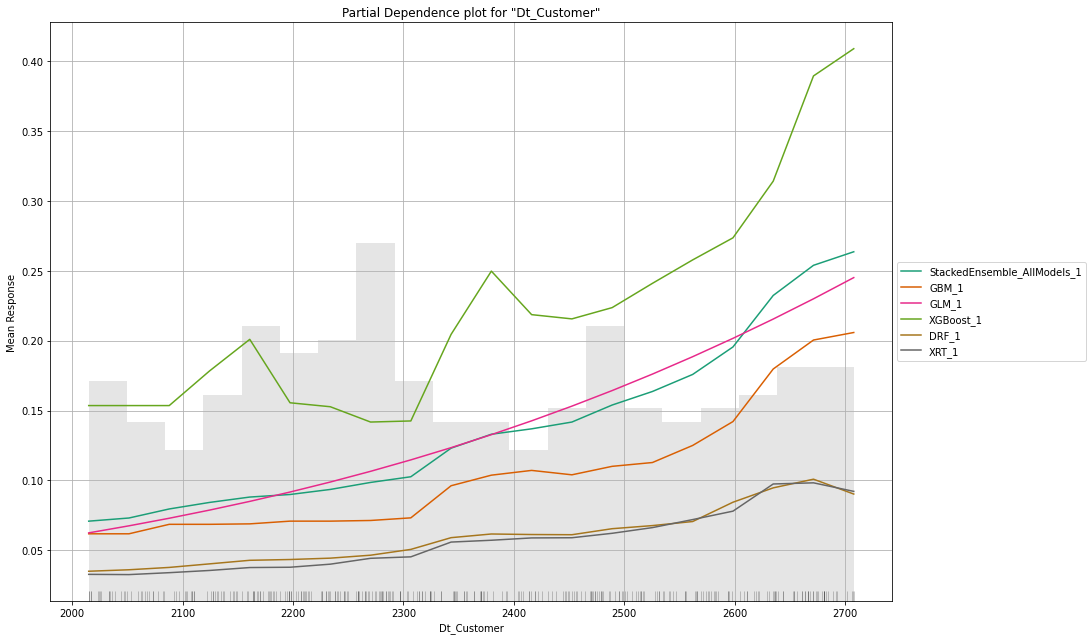

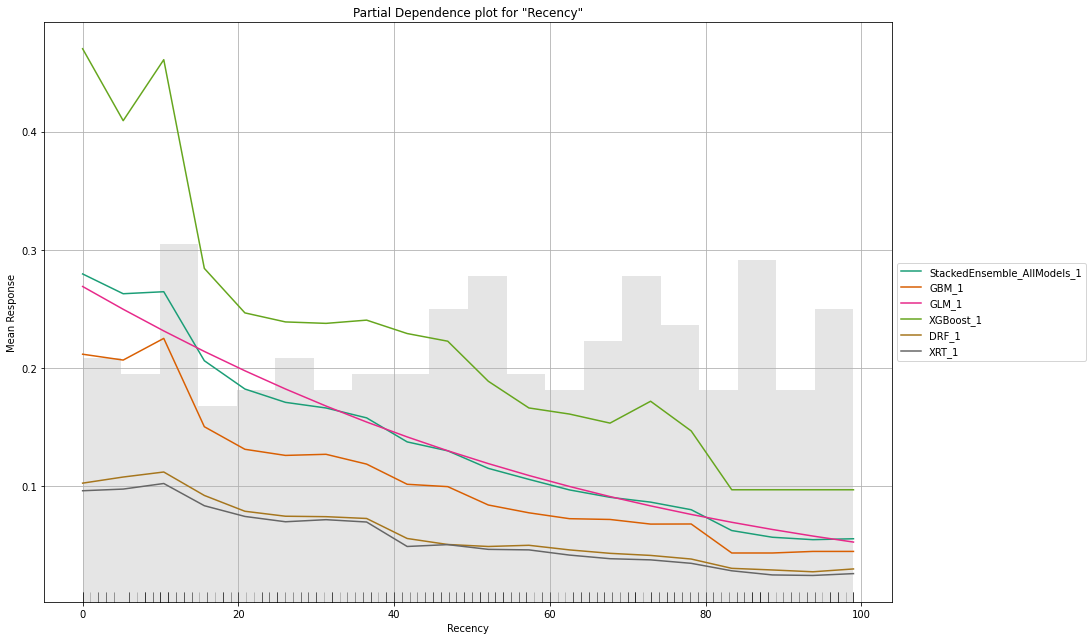

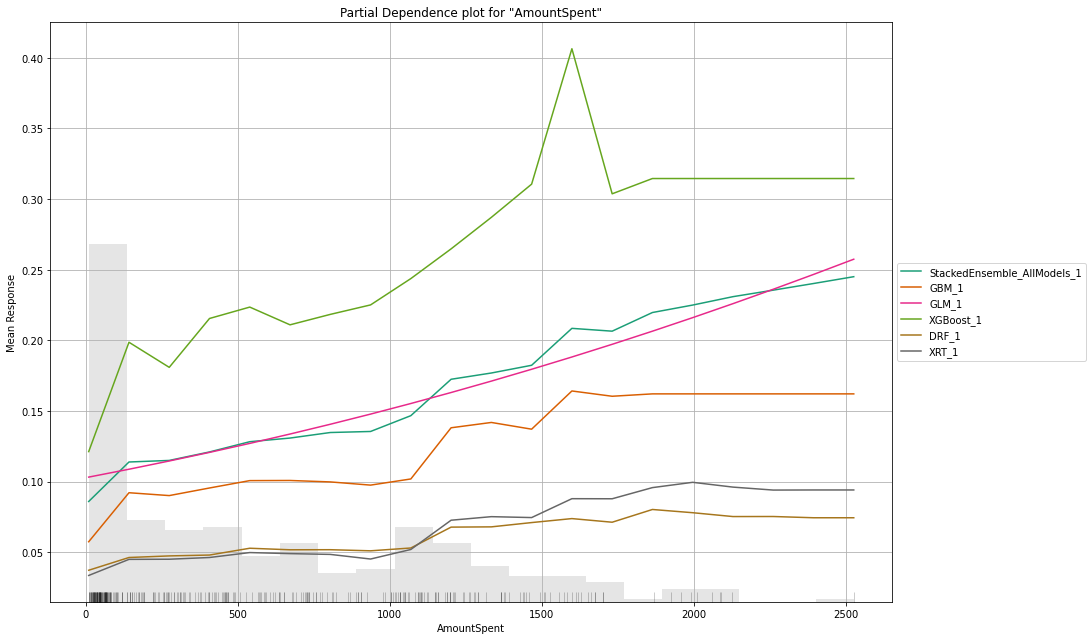

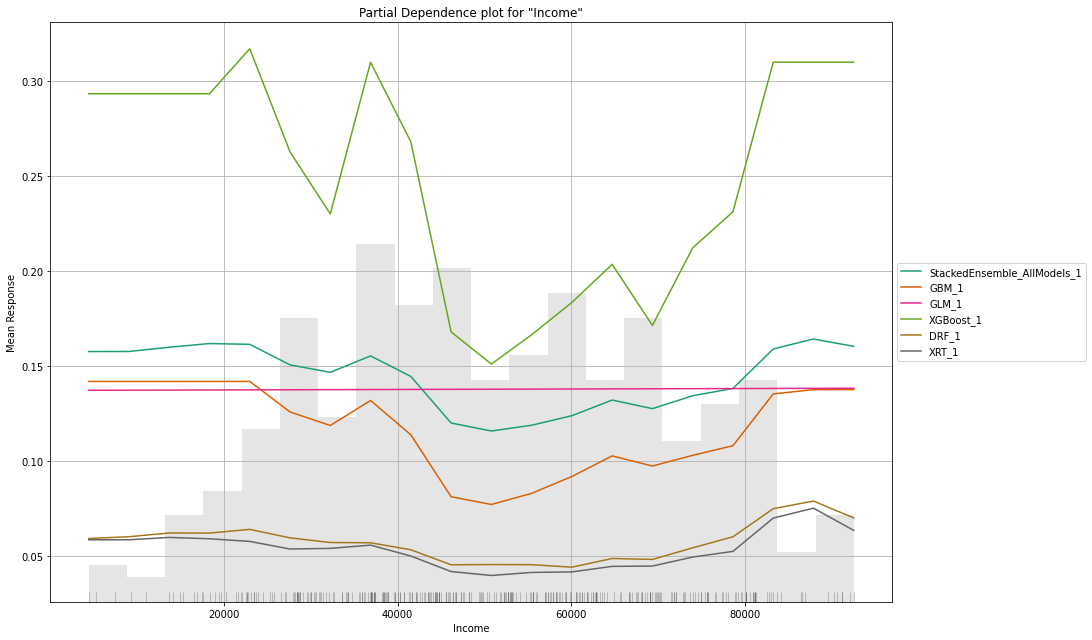

In [123]:
exa = aml.explain(test)

In [124]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Indicate which variables to compute VIF
Multic = data
#Compute VIF
vif = pd.DataFrame()
vif["variables"] = Multic.columns
vif["VIF"] = [variance_inflation_factor(Multic.values, i) for i in range(Multic.shape[1])]
vif

,variables,VIF
0,Age,1.107939
1,Education,1.056995
2,Income,5.048599
3,Dt_Customer,1.350337
4,Recency,1.062125
5,NumDealsPurchases,1.728518
6,NumWebVisitsMonth,2.299947
7,Complain,1.006528
8,Response,1.401374
9,Children,1.983516


In [125]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(data['Response'], data[["Age",	"Education",	"Income",	"Dt_Customer",	
                                       "Recency"	,"NumDealsPurchases",	"NumWebVisitsMonth",	
                                       "Complain",	"Children",	"AmountSpent"	,"NumPurchased",	
                                       "Prev_campaigns",	"Marital_Status_Couple",	"Marital_Status_Single"]]).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Response   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     67.92
Date:                Wed, 01 Mar 2023   Prob (F-statistic):          1.22e-150
Time:                        00:48:19   Log-Likelihood:                -456.83
No. Observations:                2214   AIC:                             941.7
Df Residuals:                    2200   BIC:                             1021.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Age                      -0.0002      0.001     -0.446      0.656      -0.001       0.001
Education                 0.0374      0.008      4.838      0.000       0.022       0.053
Income                 1.367e-07   7.04e-07      0.194      0.846   -1.24e-06    1.52e-06
Dt_Customer               0.0003   3.59e-05      8.492      0.000       0.000       0.000
Recency                  -0.0024      0.000    -11.106      0.000      -0.003      -0.002
NumDealsPurchases         0.0133      0.004      3.026      0.003       0.005       0.022
NumWebVisitsMonth         0.0062      0.004      1.552      0.121      -0.002       0.014
Complain                  0.0397      0.066      0.605      0.545      -0.089       0.168
Children                 -0.0430      0.012     -3.621      0.000      -0.066      -0.020
AmountSpent            8.699e-05   2.54e-05      3.421      0.001    3.71e-05       0.000
NumPurchased             -0.0069      0.002     -3.811      0.000      -0.010      -0.003
Prev_campaigns            0.1981      0.011     17.735      0.000       0.176       0.220
Marital_Status_Couple    -0.6337      0.092     -6.901      0.000      -0.814      -0.454
Marital_Status_Single    -0.5245      0.092     -5.689      0.000      -0.705      -0.344
==============================================================================
Omnibus:                      511.306   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1019.070
Skew:                           1.367   Prob(JB):                    5.15e-222
Kurtosis:                       4.890   Cond. No.                     1.13e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


All code in this note is available as open source through the MIT license.

All text and images are free to use under the Creative Commons Attribution 3.0 license. https://creativecommons.org/licenses/by/3.0/us/


MIT License

Copyright (c) 2023 Makarand Madhavi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
